# DATA SCIENCE ASSIGNMENT

In [1]:
#PACKAGES REQUIRED : pandas, numpy, scipy, matplotlib, xgboost, sklearn, imblearn
import pandas as pd
import numpy as np
from scipy import interp
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE 
%matplotlib inline 

In [2]:
df = pd.read_excel('Data Scientist Research Assignment (21.08.17).xlsx', sheetname='Data', header=0)

In [3]:
print 'Shape of the dataframe : {}'.format(df.shape) 

Shape of the dataframe : (289023, 20)


In [4]:
df['Segment'] = df['Game'] + df['Affiliate'] + df['Platform'] + df['Country'] + df['Placement'] 
print 'Number of unique segments : %s' % df['Segment'].nunique()
print 'Number of duplicated segments %s' % str((df.shape[0]) - df['Segment'].nunique())
print 'Number of negative values : %s' % np.sum((df < 0).values.ravel())
print 'We chose to remove the duplicates and keep the first occurence'
df.drop_duplicates(subset=['Segment'], keep='first', inplace=True)

Number of unique segments : 287527
Number of duplicated segments 1496
Number of negative values : 0
We chose to remove the duplicates and keep the first occurence


In [5]:
df['CTR'] = np.where(df['Impressions'] != 0, df['Clicks'] / df['Impressions'], 0)
print 'Number of CTR > 1 : %s' % len(df[df['CTR'] > 1])

Number of CTR > 1 : 2


In [6]:
df['DepositorsRate'] = np.where(df['Depositors'] != 0, df['Depositors'] / df['Installs'], 0)
print 'Number of Depositors Rate > 1 : %s' % len(df[df['DepositorsRate'] > 1])

Number of Depositors Rate > 1 : 1350


In [7]:
df = df[df['CTR'] <= 1]
df = df[df['DepositorsRate'] <= 1]
print 'We remove the segments containing these anomalies'
print 'Size of the dataframe %s' % len(df)

We remove the segments containing these anomalies
Size of the dataframe 286175


In [8]:
print 'Number of "good" segments : %s' % len(df[(df['DepositorsRate'] > 0.02)])

Number of "good" segments : 3044


In [9]:
print 'Number of Segments\' budgets < 5 : %s' % len(df[df['Spend'] < 5])
print 'For our modelisation, We have chosen to dismiss those segments because even if we predict a "good" segment in this budget range it will have a very low impact on the business'
df = df[(df['Spend'] > 5)]
print 'Size of the DF without these segments : %s' % len(df)

Number of Segments' budgets < 5 : 219229
For our modelisation, We have chosen to dismiss those segments because even if we predict a "good" segment in this budget range it will have a very low impact on the business
Size of the DF without these segments : 66613


In [10]:
print 'Number of "good" segments with budget >= 5 : %s' % len(df[(df['DepositorsRate'] > 0.02)])
print 'We have in the same time reduced the number of "negative" examples with this cut, in order to get a more balanced dataset and to remove noisy data'
print 'The number of "positive" segments is about the same which is good'

Number of "good" segments with budget >= 5 : 2829
We have in the same time reduced the number of "negative" examples with this cut, in order to get a more balanced dataset and to remove noisy data
The number of "positive" segments is about the same which is good


In [11]:
print 'Total of profitable (positive ROI) segments at a date t (t : date at which the deposits data has been retrieved) : %s' % len(df[df['Spend'] < df['DepositAmount']])
print 'Number of profitable (positive ROI) segments within the "good" ones at a date t : %s' % len(df[(df['DepositorsRate'] > 0.02) & (df['Spend'] < df['DepositAmount'])])
print 'A lot of "good" segments have a negative ROI, maybe because the ROI becomes positive after a time longer than t'
print 'Almost all the profitables segments are tagged "good", which is reassuring (466 out of 475)'

Total of profitable (positive ROI) segments at a date t (t : date at which the deposits data has been retrieved) : 474
Number of profitable (positive ROI) segments within the "good" ones at a date t : 465
A lot of "good" segments have a negative ROI, maybe because the ROI becomes positive after a time longer than t
Almost all the profitables segments are tagged "good", which is reassuring (466 out of 475)


In [12]:
df['GoodSegment'] = np.where(df['DepositorsRate'] > 0.02, 1, 0)
print 'Positive class ratio : %s' % (float(len(df[df['GoodSegment'] == 1])) / (len(df[df['GoodSegment'] == 0]) + len(df[df['GoodSegment'] == 1])))
print 'The dataset is very imbalanced, we have just a little more than 4% of positive examples'
print 'We will have to use a method in order to deal with it (oversampling of the minority class, undersampling of the majority class or set a bigger weight on the minority class)'

Positive class ratio : 0.0424691876961
The dataset is very imbalanced, we have just a little more than 4% of positive examples
We will have to use a method in order to deal with it (oversampling of the minority class, undersampling of the majority class or set a bigger weight on the minority class)


In [13]:
print 'We add the eCPC (e stands for effective), eCPM and eCR (conversion rate) features'
df['eCPC'] = np.where(df['Clicks'] != 0, df['Spend'] / df['Clicks'], 0)
df['eCPM'] = np.where(df['Impressions'] != 0, (df['Spend']*1000) / df['Impressions'], 0)
df['eCR'] = np.where(df['Impressions'] != 0, df['Installs'] / df['Impressions'], 0)

We add the eCPC (e stands for effective), eCPM and eCR (conversion rate) features


## SMAL GRAPHICAL EXPLORATION

Affiliate 1 seems to perform better than the others


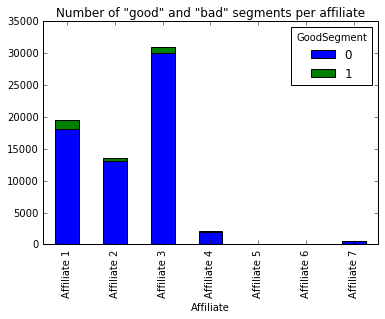

In [14]:
df.groupby(['Affiliate', 'GoodSegment']).size().unstack().plot(kind='bar',
       title='Number of "good" and "bad" segments per affiliate', stacked=True)
print 'Affiliate 1 seems to perform better than the others'

Most of the deposited ammount is made on "good" segments which is reassuring


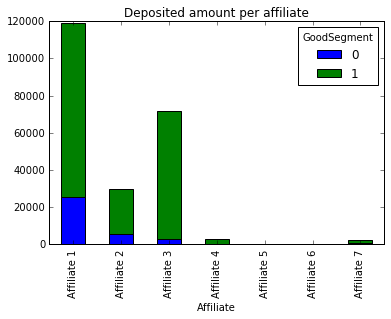

In [15]:
df.groupby(['Affiliate','GoodSegment'])['DepositAmount'].sum().unstack().plot(kind='bar',
      title='Deposited amount per affiliate', stacked=True)
print 'Most of the deposited ammount is made on "good" segments which is reassuring'

The average ROI is very low. We should focus our effort on affiliates with high ROI


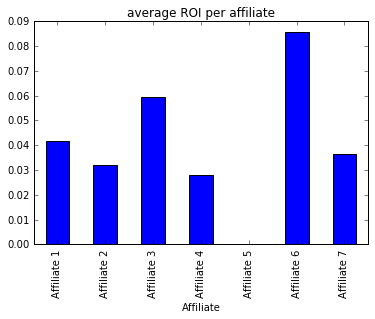

In [16]:
(df.groupby(['Affiliate'])['DepositAmount'].sum() / df.groupby(['Affiliate'])['Spend'].sum()).plot(
    title='average ROI per affiliate', kind='bar')
print 'The average ROI is very low. We should focus our effort on affiliates with high ROI'

We notice WW seems the value given for an unknown value


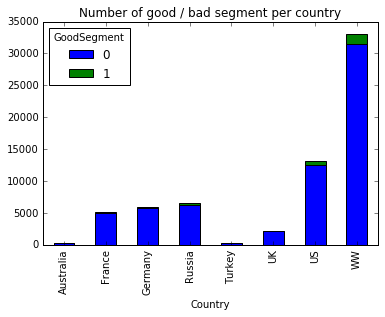

In [17]:
df.groupby(['Country', 'GoodSegment']).size().unstack().plot(kind='bar',
    title = 'Number of good / bad segment per country', stacked=True)
print 'We notice WW seems the value given for an unknown value'

The most advertised, and perhaps the most played game is Vikings
Terminator's campaings seems to outperfom the other games campaings


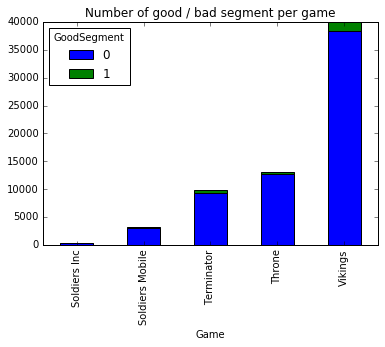

In [18]:
df.groupby(['Game', 'GoodSegment']).size().unstack().plot(kind='bar',
         title = 'Number of good / bad segment per game', stacked=True)
print 'The most advertised, and perhaps the most played game is Vikings'
print 'Terminator\'s campaings seems to outperfom the other games campaings'

Mobile platforms segments seems more profitable than web ones


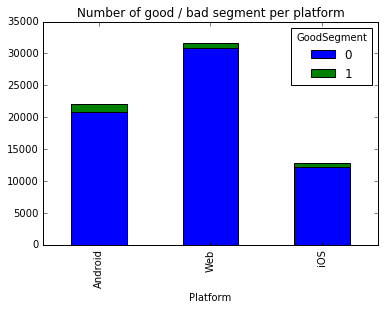

In [19]:
df.groupby(['Platform', 'GoodSegment']).size().unstack().plot(kind='bar', 
              title = 'Number of good / bad segment per platform', stacked=True)
print 'Mobile platforms segments seems more profitable than web ones'

Axes(0.125,0.125;0.775x0.775)
The chart below shows a bias for the Spend feature.
The more the expense is important, the more the probability the segment is good is important which should not be the case in reality
In fact, we can spend a lot of money on a low quality segment and spend few money on a high quality one.


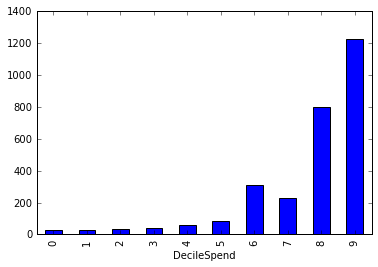

In [20]:
df["DecileSpend"] = pd.qcut(df['Spend'], 10, labels=False)
print df[df['GoodSegment'] == 1].groupby(['DecileSpend']).size().plot(kind='bar', stacked=True)
print 'The chart below shows a bias for the Spend feature.'
print 'The more the expense is important, the more the probability the segment is good is important which should not be the case in reality'
print 'In fact, we can spend a lot of money on a low quality segment and spend few money on a high quality one.'
del df["DecileSpend"]

Axes(0.125,0.125;0.775x0.775)
The chart below is more informative than the one just above.
We see that a higher effective CPC induces a higher "good" segment probability.
This seems normal. Paying more on a click means the quality of the ad is better and the depositor rate higher.
We could do further investigations on the CPC, trying to find its optimum, in terms of money spend and depositor rate.


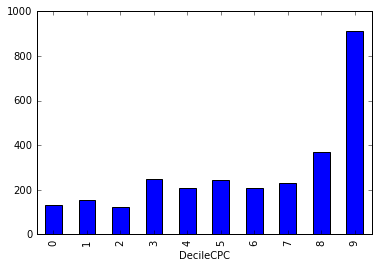

In [21]:
df["DecileCPC"] = pd.qcut(df['eCPC'], 10, labels=False)
print df[df['GoodSegment'] == 1].groupby(['DecileCPC']).size().plot(kind='bar', stacked=True)
print 'The chart below is more informative than the one just above.'
print 'We see that a higher effective CPC induces a higher "good" segment probability.'
print 'This seems normal. Paying more on a click means the quality of the ad is better and the depositor rate higher.'
print 'We could do further investigations on the CPC, trying to find its optimum, in terms of money spend and depositor rate.'
del df["DecileCPC"]

The conversion rate is 2.5 times higher for "good" segments


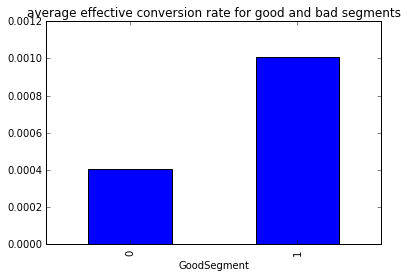

In [22]:
df.groupby(['GoodSegment'])['eCR'].mean().plot(kind='bar', 
                                               title="average effective conversion rate for good and bad segments")

print 'The conversion rate is 2.5 times higher for "good" segments'

In [23]:
print 'We couldn\'t cover the specificities of the whole dataset in this analysis.' 
print 'We could extend this work in the future.'

We couldn't cover the specificities of the whole dataset in this analysis.
We could extend this work in the future.


In [24]:
print 'We one-hot encode the categorical features'
print 'We create the matrix X  and the labels\' vector y '
print "We discard these features : ['DepositorsRate','Placement', 'Depositors', 'Deposits', 'DepositAmount', 'Segment', 'Spend']"
Xy = pd.get_dummies(df.drop(['DepositorsRate','Placement', 'Depositors', 'Deposits', 'DepositAmount', 'Segment', 'Spend'], axis=1), columns = ['Game', 'Affiliate','Platform', 'Country'])
X = Xy.drop('GoodSegment', axis=1)
y = Xy['GoodSegment']

We one-hot encode the categorical features
We create the matrix X  and the labels' vector y 
We discard these features : ['DepositorsRate','Placement', 'Depositors', 'Deposits', 'DepositAmount', 'Segment', 'Spend']


In [25]:
print 'We check the types of the variables \n'
print X.dtypes
print 'We check the values \n'
print X.describe()

We check the types of the variables 

Impressions                int64
Clicks                     int64
Installs                   int64
FiveBattles                int64
FiveLevels                 int64
ClanJoins                  int64
FiveMinutes                int64
TenMinutes                 int64
DayOneRetentions           int64
DaySevenRetentions         int64
DayThirtyRetentions        int64
CTR                      float64
eCPC                     float64
eCPM                     float64
eCR                      float64
Game_Soldiers Inc        float64
Game_Soldiers Mobile     float64
Game_Terminator          float64
Game_Throne              float64
Game_Vikings             float64
Affiliate_Affiliate 1    float64
Affiliate_Affiliate 2    float64
Affiliate_Affiliate 3    float64
Affiliate_Affiliate 4    float64
Affiliate_Affiliate 5    float64
Affiliate_Affiliate 6    float64
Affiliate_Affiliate 7    float64
Platform_Android         float64
Platform_Web             float64
Platf

In [97]:
# DO NOT RUN FOR TESTING
# WITH GRADIENT BOOSTING MODEL, THIS STEP IS NOT VERY RELEVANT BECAUSE THE TREES ARE ROBUST TO UNBOUNDED VALUES 
# BUT SOMETIMES IT CAN HELP
print 'We scale the unbounded features'
scaler = StandardScaler()
StandardScaler(copy = True, with_mean=True, with_std=True)
scaler.fit_transform(X)
toScale = ['Impressions','Clicks','Installs','FiveBattles','FiveLevels','ClanJoins','Spend',
         'FiveMinutes','TenMinutes','DayOneRetentions','DaySevenRetentions','DayThirtyRetentions']
X[toScale] = scaler.fit_transform(X[toScale])

/Users/mac/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-09-06 14:21:13.579047. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
# OLD STUFF, I was planning to do the modelisation with a regression on the DepositorsRate
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
reg = XGBRegressor()  # and for classifier  
mdl = reg.fit(X_train, y_train)  
#reg.predict(X_test)  
np.mean(cross_val_score(reg, X_train, y_train, scoring='r2', cv=10))

In [172]:
#DO NOT RUN FOR TESTING, IT CAN BE LONG
print "We perform a cross validated grid search on several parameters"
print "The parameter scale_pos_weight is important in our modelisation because it allows to penalize more or less the positive (minority) class in the cost function"
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 22)
parameters = { 'max_depth': [3,4,5], 'learning_rate':[0.05,0.1], 'n_estimators':[20,50,100], 'scale_pos_weight':[1,3,5,7,9,11]}
gbt = XGBClassifier() 
clf = GridSearchCV(gbt, parameters, cv = skf, scoring = 'f1')
clf.fit(X,y)

We perform a grid search on several parameters
The parameter scale_pos_weight is very much important in our modelisation because it allows to penalize more or less the positive class in the cost function


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 50, 100], 'scale_pos_weight': [1, 3, 5, 7, 9, 11], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

/Users/mac/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-09-06 22:47:25.805849. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [178]:
#DO NOT RUN FOR TESTING, RESULT OF GRIDSEARCH
print clf.cv_results_
print clf.best_score_
print clf.best_params_

{'param_scale_pos_weight': masked_array(data = [1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9
 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5
 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1 3 5 7 9 11 1
 3 5 7 9 11],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False],
       fill_value = ?)
, 'rank_tes

/Users/mac/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-09-07 07:31:42.650611. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
print "We have decided to use a gradient boosting algorithm, because it provides very good results for prediction problems"
print "The model is complex but tend to not overfit too much."
print "It is robust to noisy training data, robust to correlated features, robut to large interval features."
print "It has a parameter to handle imbalanced data."
print "\nWe have chosen to optimize and calculate the model performances with the F1-score metric because it takes in account the fact the dataset is imbalanced instead of the ROC AUC or accuracy"
print 'We shuffle and stratify the different sets for cross validation error testing with 10 splits'
print 'After training and testing on the 10 splits we average the differents metrics'
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 22)
skf.get_n_splits(X, y)

# PARAMETERS FOUND IN THE GRIDSEARCH
clf = XGBClassifier(n_estimators= 100, scale_pos_weight= 3, learning_rate= 0.1, max_depth= 5) 

sc = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # OVERSAMPLING AND UNDERSAMPLING HAVE BEEN TESTED AND GIVE WORST RESULTS THAN THE TWEAKING OF THE scale_pos_weight   
    # OVERSAMPLING
    #nm = SMOTE(random_state=42)
    # UNDERSAMPLING
    #nm = NearMiss(random_state=42)
    # X_train, y_train = nm.fit_sample(X_train, y_train)
    mdl = clf.fit(X_train, y_train.ravel())
    sc.append(precision_recall_fscore_support(y_test, mdl.predict(X_test), average = 'binary')[0:-1])

print 'With standard threshold of 0.5 \nPrecision : %s, \nRecall : %s, \nF1-Score : %s' % (np.mean(sc, axis=0)[0], np.mean(sc, axis=0)[1], np.mean(sc, axis=0)[2])                  

We have decided to use a gradient boosting algorithm, because it provides very good results for prediction problems
The model is complex but tend to not overfit too much.
It is robust to noisy training data, robust to correlated features, robut to large interval features.
It has a parameter to handle imbalanced data.

We have chosen to optimize and calculate the model performances with the F1-score metric because it takes in account the fact the dataset is imbalanced instead of the ROC AUC or accuracy
We shuffle and stratify the different sets for cross validation error testing with 10 splits
After training and testing on the 10 splits we average the differents metrics
With standard threshold of 0.5 
Precision : 0.437500887013, 
Recall : 0.493104528482, 
F1-Score : 0.463499643983


Precision-recall curve plotted for the last (10th) fold

[QUOTE http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html]
A system with high recall but low precision returns many results, but most of its predicted labels are incorrect.
A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct.
[END QUOTE]

Depending on our marketing strategy, sometimes we would prefer to have a high recall, sometimes a high precision. The best, of course, would be to have both high.
For our study we have decided to balance the two by picking the best f1-score, which is the harmonic mean of these two metrics


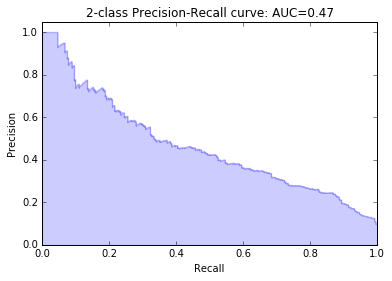

In [27]:
print 'Precision-recall curve plotted for the last (10th) fold\n'
print '[QUOTE http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html]'
print 'A system with high recall but low precision returns many results, but most of its predicted labels are incorrect.'
print 'A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct.'
print '[END QUOTE]\n'
print 'Depending on our marketing strategy, sometimes we would prefer to have a high recall, sometimes a high precision. The best, of course, would be to have both high.'
print 'For our study we have decided to balance the two by picking the best f1-score, which is the harmonic mean of these two metrics'
precision, recall, _ = precision_recall_curve(y_test, mdl.predict_proba(X_test)[:,1])
average_precision = average_precision_score(y_test, mdl.predict_proba(X_test)[:,1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))
plt.show()

Feature importance barchart plotted for the last (10th) fold

The most important feature is the eCPC which seems ok. It indicates some kind of quality in the segment.
Discarding the Spend feature allowed us to remove the bias it induced.
The in-game features are also important and summed they come first in importance which is a good news



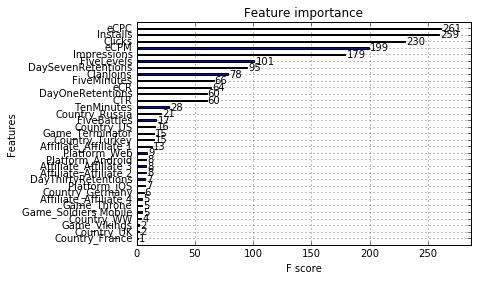

In [28]:
print 'Feature importance barchart plotted for the last (10th) fold\n'
xgb.plot_importance(mdl)
print 'The most important feature is the eCPC which seems ok. It indicates some kind of quality in the segment.'
print 'Discarding the Spend feature allowed us to remove the bias it induced.'
print 'The in-game features are also important and summed they come first in importance which is a good news\n'

In [29]:
print 'We train the model on the training set and we predict the probas on this same set'
mdl = clf.fit(X, y)
prob = mdl.predict_proba(X)

df["proba_0"] = prob[:,0]
df["proba_1"] = prob[:,1]

print df.head()

We train the model on the training set and we predict the probas on this same set
         Game    Affiliate Platform Country        Placement  Impressions  \
0     Vikings  Affiliate 3      Web      US  Placement 16881      6396124   
1     Vikings  Affiliate 3      Web      US  Placement 17647     11814535   
2     Vikings  Affiliate 3      Web      US  Placement 17768      7848002   
3  Terminator  Affiliate 1      iOS      US   Placement 3669       364361   
4  Terminator  Affiliate 1      iOS      US   Placement 3701       391893   

   Clicks  Installs  FiveBattles  FiveLevels    ...     DepositAmount  \
0   19440       465            0          13    ...          12811.50   
1   17551       589            0          15    ...          14355.63   
2   10212       335            2           4    ...            136.50   
3    1070       237            6           4    ...            259.74   
4    1095       195            6           8    ...            110.50   

                

In [30]:
print 'To build a better modelisation :'
print '- We can add more variables like dates & timed variables, real cpc and cpm of the campaigns, information about the placement (type of ad, website ad, mobile ad...), more in-game stats, info about the devices used ...'
print '- We can increase the number of training data and good segments'
print '- We can use a regression model instead.'
print '  Using a regression model will capture more information. When we categorize the DepositorsRate in two class we lose a lot of information'
print '- If we have a lot of data, we can train a deep neural network'
print '- We could try also try to predict the DepositAmount, or the ROI'

To build a better modelisation :
- We can add more variables like dates & timed variables, real cpc and cpm of the campaigns, information about the placement (type of ad, website ad, mobile ad...), more in-game stats, info about the devices used ...
- We can increase the number of training data and good segments
- We can use a regression model instead.
  Using a regression model will capture more information. When we categorize the DepositorsRate in two class we lose a lot of information
- If we have a lot of data, we can train a deep neural network
- We could try also try to predict the DepositAmount, or the ROI


In [31]:
print 'Conclusion : \n'
print 'The results of the modelisation are satisfying considering the traits of our training dataset (F1-score ~ 0.5).'
print 'The set is imbalanced and the signal in the features is a bit weak for our classification problem.'
print 'If our goal is to be able to identify some of the good segments without too many false positive, our model is fine.'
print '\nOne other thing is : We use data from the future (in-game data, campaigns stats) to predict' 
print 'something we will want to use in the present in order to help us to take decisions about how and where to spend money, which is a bit weird'

Conclusion : 

The results of the modelisation are satisfying considering the traits of our training dataset (F1-score ~ 0.5).
The set is imbalanced and the signal in the features is a bit weak for our classification problem.
If our goal is to be able to identify some of the good segments without too many false positive, our model is fine.

One other thing is : We use data from the future (in-game data, campaigns stats) to predict
something we will want to use in the present in order to help us to take decisions about how and where to spend money, which is a bit weird


In [32]:
print 'UPDATE \n'
print 'I\'ve decided to discard the Spend feature in order to get a more robust prediction and instead adding campaign KPIs features.'
print 'The metrics for the previous model gave slightly better results but this was certainly due to the overfitting on the Spend feature'
print 'I\'m more confident with this model and I think its power of generalization will be better.'

UPDATE 

I've decided to discard the Spend feature in order to get a more robust prediction and instead adding campaign KPIs features.
The metrics for the previous model gave slightly better results but this was certainly due to the overfitting on the Spend feature
I'm more confident with this model and I think its power of generalization will be better.
